In [1]:
from yadlt.model import generate_pdf_model, compute_K_by_layer, compute_kernel_from_recursion
from yadlt.load_data import load_bcdms_grid

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.gridspec import GridSpec
import numpy as np

rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
rc("text", usetex=True)
rc("text.latex", preamble=r"\usepackage{amsmath,amssymb}")

In [2]:
import logging
from yadlt.log import setup_logger

# Set up the root logger to capture all logs in jupyter notebook
logger = setup_logger()

# If you want to see all messages, including DEBUG:
logger.setLevel(logging.INFO)

In [3]:
fk_grid = load_bcdms_grid()
x = np.array(fk_grid).reshape(1, -1, 1)

In [4]:
seed = 232123
nreplicas = 1000
model_ens_nnpdf = []
model_ens_100 = []
model_ens_600 = []

common_dict = {
    "outputs": 1,
    "activations": ["tanh", "tanh"],
    "kernel_initializer": "GlorotNormal",
    "user_ki_args": None,
    "scaled_input": False,
    "preprocessing": False,
}

for rep in range(nreplicas):
    model_ens_nnpdf.append(generate_pdf_model(**common_dict, architecture=(25, 20), seed=seed+rep))
    model_ens_100.append(generate_pdf_model(**common_dict, architecture=(100, 100), seed=seed+rep))
    model_ens_600.append(generate_pdf_model(**common_dict, architecture=(600, 600), seed=seed+rep))

In [5]:
# For the NNPDF case, increase the number of replicas to 1000

layer = 1
n_in = model_ens_nnpdf[0].layers[1].layers[layer].kernel.shape[0]
n_out = model_ens_nnpdf[0].layers[1].layers[layer].kernel.shape[1]

W_100 = []
W_1000 = []
W_5000 = []

for mod in model_ens_nnpdf:
    W = mod.layers[1].layers[layer].kernel[0,14].numpy()
    W_100.append(W)

for rep in range(1000):
    model = generate_pdf_model(**common_dict, architecture=(25, 20), seed=seed+rep)
    W = model.layers[1].layers[layer].kernel[0,14].numpy()
    W_1000.append(W)

for rep in range(5000):
    model = generate_pdf_model(**common_dict, architecture=(25, 20), seed=seed+rep)
    W = model.layers[1].layers[layer].kernel[0,14].numpy()
    W_5000.append(W)

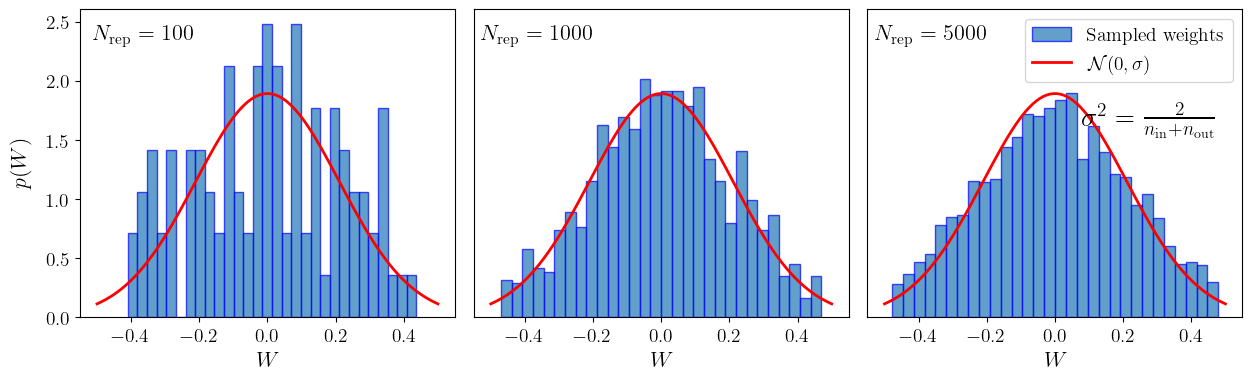

In [6]:
from scipy import stats

# Create figure and grid
fig = plt.figure(figsize=(15, 4))
gs = GridSpec(1, 3, figure=fig, hspace=0.05, wspace=0.05)

sigma = np.sqrt(2 / (n_in + n_out))
pdf_x_vals = np.linspace(-0.5, 0.5, 100)
gaussian = stats.norm.pdf(pdf_x_vals, 0, sigma)

ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1],sharey=ax_1)
ax_3 = fig.add_subplot(gs[0, 2],sharey=ax_1)

ax_1.hist(W_100, bins=30, density=True, alpha=0.7, color='C0', edgecolor='blue')
ax_2.hist(W_1000, bins=30, density=True, alpha=0.7, color='C0', edgecolor='blue')
ax_3.hist(W_5000, bins=30, density=True, alpha=0.7, color='C0', edgecolor='blue', label=r'$\textrm{Sampled weights}$')

ax_1.plot(pdf_x_vals, gaussian, 'r-', linewidth=2, label=r'$\mathcal{N}(0,\sigma)$')
ax_2.plot(pdf_x_vals, gaussian, 'r-', linewidth=2, label=r'$\mathcal{N}(0,\sigma)$')
ax_3.plot(pdf_x_vals, gaussian, 'r-', linewidth=2, label=r'$\mathcal{N}(0,\sigma)$')

ax_1.tick_params(axis='both', which='both', labelsize=14)
ax_2.tick_params(axis='both', which='both', labelsize=14)
ax_3.tick_params(axis='both', which='both', labelsize=14)

ax_2.tick_params(axis='y', which='both', left=False, labelleft=False)
ax_3.tick_params(axis='y', which='both', left=False, labelleft=False)

ax_1.set_xlabel(r'$W$', fontsize=16)
ax_2.set_xlabel(r'$W$', fontsize=16)
ax_3.set_xlabel(r'$W$', fontsize=16)

ax_1.set_ylabel(r"$p(W)$", fontsize=16, labelpad=10)

ax_3.text(x=0.75, y=0.70, s=r'$\sigma^2 = \frac{2}{n_{\rm in} + n_{\rm out}}$', fontsize=20, ha='center', va='top', transform=ax_3.transAxes)

ax_1.text(x=0.17, y=0.95, s=r'$N_{\rm rep}=100$', fontsize=16, ha='center', va='top', transform=ax_1.transAxes)
ax_2.text(x=0.17, y=0.95, s=r'$N_{\rm rep}=1000$', fontsize=16, ha='center', va='top', transform=ax_2.transAxes)
ax_3.text(x=0.17, y=0.95, s=r'$N_{\rm rep}=5000$', fontsize=16, ha='center', va='top', transform=ax_3.transAxes)

ax_3.legend(fontsize=14)

fig.savefig("../doc/figs/weight_distribution.pdf", bbox_inches='tight')

# Compute kernel elements

In [5]:
K1_empirical_nnpdf = compute_K_by_layer(model_ens_nnpdf, 0, fk_grid, neuron_pairs=(0, 0))
K2_empirical_nnpdf = compute_K_by_layer(model_ens_nnpdf, 1, fk_grid, neuron_pairs=(0, 0))
Kout_empirical_nnpdf = compute_K_by_layer(model_ens_nnpdf, 2, fk_grid, neuron_pairs=(0, 0))

K1_empirical_100 = compute_K_by_layer(model_ens_100, 0, fk_grid)
K2_empirical_100 = compute_K_by_layer(model_ens_100, 1, fk_grid)
Kout_empirical_100 = compute_K_by_layer(model_ens_100, 2, fk_grid)

K1_empirical_600 = compute_K_by_layer(model_ens_600, 0, fk_grid)
K2_empirical_600 = compute_K_by_layer(model_ens_600, 1, fk_grid)
Kout_empirical_600 = compute_K_by_layer(model_ens_600, 2, fk_grid)

In [6]:
K1_th_nnpdf = compute_kernel_from_recursion(model_ens_nnpdf[0], 0, tuple(fk_grid), num_samples=100000, batch_size=100)
K2_th_nnpdf = compute_kernel_from_recursion(model_ens_nnpdf[0], 1, tuple(fk_grid), num_samples=100000, batch_size=100)
Kout_th_nnpdf = compute_kernel_from_recursion(model_ens_nnpdf[0], 2, tuple(fk_grid), num_samples=100000, batch_size=100)

K1_th_100 = compute_kernel_from_recursion(model_ens_100[0], 0, tuple(fk_grid), num_samples=100000, batch_size=100)
K2_th_100 = compute_kernel_from_recursion(model_ens_100[0], 1, tuple(fk_grid), num_samples=100000, batch_size=100)
Kout_th_100 = compute_kernel_from_recursion(model_ens_100[0], 2, tuple(fk_grid), num_samples=100000, batch_size=100)

K1_th_600 = compute_kernel_from_recursion(model_ens_600[0], 0, tuple(fk_grid), num_samples=100000, batch_size=100)
K2_th_600 = compute_kernel_from_recursion(model_ens_600[0], 1, tuple(fk_grid), num_samples=100000, batch_size=100)
Kout_th_600 = compute_kernel_from_recursion(model_ens_600[0], 2, tuple(fk_grid), num_samples=100000, batch_size=100)

size of layer 1: 1 -> 25
size of layer 1: 1 -> 25
size of layer 2: 25 -> 20
size of layer 1: 1 -> 25
size of layer 2: 25 -> 20
size of layer 3: 20 -> 1
size of layer 1: 1 -> 100
size of layer 1: 1 -> 100
size of layer 2: 100 -> 100
size of layer 1: 1 -> 100
size of layer 2: 100 -> 100
size of layer 3: 100 -> 1
size of layer 1: 1 -> 600
size of layer 1: 1 -> 600
size of layer 2: 600 -> 600
size of layer 1: 1 -> 600
size of layer 2: 600 -> 600
size of layer 3: 600 -> 1


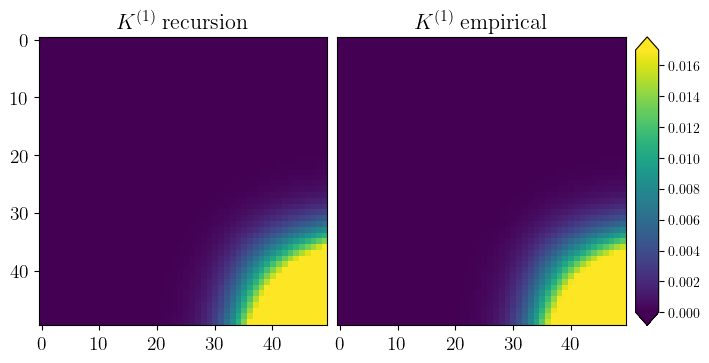

In [ ]:
from matplotlib.colors import LogNorm

# Create figure and grid
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1, 3, figure=fig, wspace=0.05, width_ratios=[1, 1, 0.08])

ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1])
cax = fig.add_subplot(gs[0, 2])

vmin = min(np.percentile(A, 1) for A in [K1_th_nnpdf, K1_empirical_nnpdf])
vmax = max(np.percentile(A, 95) for A in [K1_th_nnpdf, K1_empirical_nnpdf])
norm = plt.Normalize(vmin=vmin, vmax=vmax)

ax_1.matshow(K1_th_nnpdf, cmap='viridis', norm=norm)
ms = ax_2.matshow(K1_empirical_nnpdf, cmap='viridis', norm=norm)

ax_1.tick_params(axis='both', which='both', labelsize=14, labelleft=True, labelbottom=True, labeltop=False, top=False)
ax_2.tick_params(axis='both', which='both', labelsize=14, labelleft=False, labelbottom=True, labeltop=False, top=False, left=False)

ax_1.set_title(r"$K^{(1)}~\textrm{recursion}$", fontsize=16)
ax_2.set_title(r"$K^{(1)}~\textrm{empirical}$", fontsize=16)

cbar = plt.colorbar(ms, cax=cax, extend="both", orientation="vertical")
pos = ax_2.get_position()
cax_pos = cax.get_position()
cax.set_position([cax_pos.x0, pos.y0, cax_pos.width, pos.height])

fig.savefig("../doc/figs/section_2/K1_correlations.pdf", bbox_inches='tight')

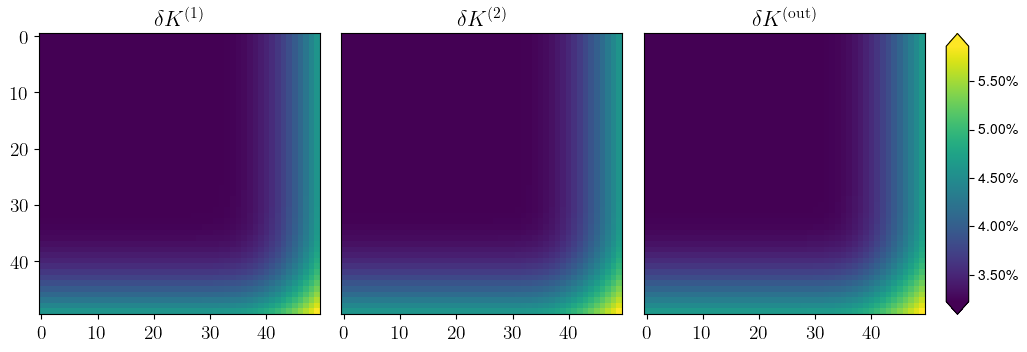

In [13]:
from matplotlib.ticker import PercentFormatter
from pathlib import Path

THIS = Path.cwd().parent / "doc/figs"

# Create figure and grid
fig = plt.figure(figsize=(4*3, 4))
gs = GridSpec(1, 4, figure=fig, wspace=0.1, width_ratios=[1, 1, 1, 0.08])

ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1])
ax_3 = fig.add_subplot(gs[0, 2])
cax = fig.add_subplot(gs[0, 3])

ratio_1 = np.abs(K1_empirical_nnpdf -  K1_th_nnpdf) / K1_th_nnpdf
ratio_2 = np.abs(K2_empirical_nnpdf -  K2_th_nnpdf) / K2_th_nnpdf
ratio_3 = np.abs(Kout_empirical_nnpdf -  Kout_th_nnpdf) / Kout_th_nnpdf

vmin = min(np.percentile(A, 1) for A in [ratio_1, ratio_2, ratio_3])
vmax = max(np.percentile(A, 95) for A in [ratio_1, ratio_2, ratio_3])
norm = plt.Normalize(vmin=vmin, vmax=vmax)

_ = ax_1.matshow(ratio_1, cmap='viridis')
_ = ax_2.matshow(ratio_2, cmap='viridis')
ms = ax_3.matshow(ratio_3, cmap='viridis')

ax_1.tick_params(axis='both', which='both', labelsize=14, labelleft=True, labelbottom=True, labeltop=False, top=False)
ax_1.set_title(r"$\delta K^{(1)}$", fontsize=16)

ax_2.tick_params(axis='both', which='both', labelsize=14, labelleft=False, labelbottom=True, labeltop=False, top=False, left=False)
ax_2.set_title(r"$\delta K^{(2)}$", fontsize=16)

ax_3.tick_params(axis='both', which='both', labelsize=14, labelleft=False, labelbottom=True, labeltop=False, top=False, left=False)
ax_3.set_title(r"$\delta K^{({\rm out})}$", fontsize=16)

cbar = plt.colorbar(ms, cax=cax, extend="both", orientation="vertical", )
pos = ax_3.get_position()
cax_pos = cax.get_position()
cax.set_position([cax_pos.x0, pos.y0, cax_pos.width, pos.height])
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1))

fig.savefig(THIS / "section_2/delta_K.pdf", bbox_inches='tight')

Are close False


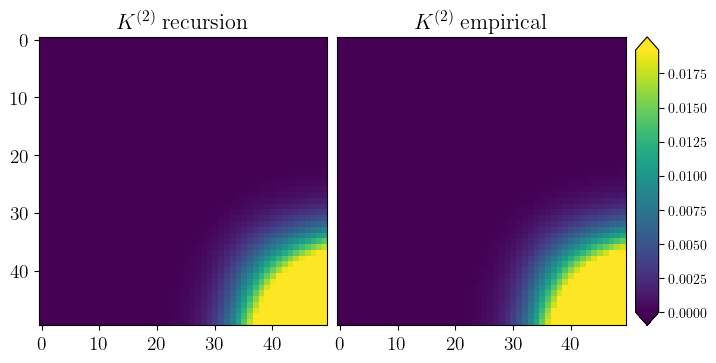

In [ ]:
# Create figure and grid
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1, 3, figure=fig, wspace=0.05, width_ratios=[1, 1, 0.08])

ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1])
cax = fig.add_subplot(gs[0, 2])

vmin = min(np.percentile(A, 1) for A in [K2_th_nnpdf, K2_empirical_nnpdf])
vmax = max(np.percentile(A, 95) for A in [K2_th_nnpdf, K2_empirical_nnpdf])
norm = plt.Normalize(vmin=vmin, vmax=vmax)

print(f"Are close {np.allclose(K2_th_nnpdf, K2_empirical_nnpdf)}")
ax_1.matshow(K2_th_nnpdf, cmap='viridis', norm=norm)
ms = ax_2.matshow(K2_empirical_nnpdf, cmap='viridis', norm=norm)

ax_1.tick_params(axis='both', which='both', labelsize=14, labelleft=True, labelbottom=True, labeltop=False, top=False)
ax_2.tick_params(axis='both', which='both', labelsize=14, labelleft=False, labelbottom=True, labeltop=False, top=False, left=False)

ax_1.set_title(r"$K^{(2)}~\textrm{recursion}$", fontsize=16)
ax_2.set_title(r"$K^{(2)}~\textrm{empirical}$", fontsize=16)

cbar = plt.colorbar(ms, cax=cax, extend="both", orientation="vertical")
pos = ax_2.get_position()
cax_pos = cax.get_position()
cax.set_position([cax_pos.x0, pos.y0, cax_pos.width, pos.height])

fig.savefig("../doc/figs/section_2/K2_correlations.pdf", bbox_inches='tight')

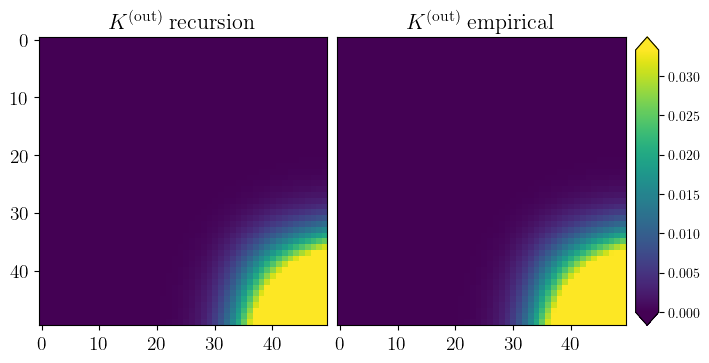

In [ ]:
from matplotlib.colors import LogNorm

# Create figure and grid
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1, 3, figure=fig, wspace=0.05, width_ratios=[1, 1, 0.08])

ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1])
cax = fig.add_subplot(gs[0, 2])

vmin = min(np.percentile(A, 1) for A in [Kout_th_nnpdf, Kout_empirical_nnpdf])
vmax = max(np.percentile(A, 95) for A in [Kout_th_nnpdf, Kout_empirical_nnpdf])
norm = plt.Normalize(vmin=vmin, vmax=vmax)

ax_1.matshow(Kout_th_nnpdf, cmap='viridis', norm=norm)
ms = ax_2.matshow(Kout_empirical_nnpdf, cmap='viridis', norm=norm)

ax_1.tick_params(axis='both', which='both', labelsize=14, labelleft=True, labelbottom=True, labeltop=False, top=False)
ax_2.tick_params(axis='both', which='both', labelsize=14, labelleft=False, labelbottom=True, labeltop=False, top=False, left=False)

ax_1.set_title(r"$K^{(\rm out)}~\textrm{recursion}$", fontsize=16)
ax_2.set_title(r"$K^{(\rm out)}~\textrm{empirical}$", fontsize=16)

cbar = plt.colorbar(ms, cax=cax, extend="both", orientation="vertical")
pos = ax_2.get_position()
cax_pos = cax.get_position()
cax.set_position([cax_pos.x0, pos.y0, cax_pos.width, pos.height])

fig.savefig("../doc/figs/section_2/K3_correlations.pdf", bbox_inches='tight')